In [1]:
import pickle
import numpy as np
from matplotlib.pyplot import figure
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [2]:
with open("../input/smart-reply-sentence-similarity-using-annoy/target_texts.pickle", 'rb') as handle:
    target_texts = pickle.load(handle)

In [3]:
len(target_texts)

21861

In [4]:
tqdm.pandas()
target_similarity_matrix = pd.read_csv("../input/smart-reply-clean-annoy-target-similarity/target_similarity_matrix_float.csv", header=None)
target_similarity_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,21851,21852,21853,21854,21855,21856,21857,21858,21859,21860
0,0.000000,0.624848,0.314564,0.654934,1.294268,1.364455,0.938746,1.383702,1.292668,0.660964,...,1.409477,1.395588,1.390710,1.355762,0.687141,1.349455,1.402012,0.653049,1.311919,0.956238
1,0.624848,0.000000,0.589709,0.807700,1.285767,1.341164,0.823230,1.350526,1.294159,0.808111,...,1.397494,1.375932,1.362597,0.911160,0.820518,1.339717,1.392230,0.772044,1.281263,0.973519
2,0.314564,0.589709,0.000000,0.881516,1.287673,1.334015,0.884419,1.362229,1.257278,0.883174,...,1.391326,1.365764,1.355997,1.313436,0.876100,1.329372,1.374006,0.873905,1.239146,0.676827
3,0.654934,0.807700,0.881516,0.000000,1.284081,1.399736,1.098558,1.410195,1.336739,0.077397,...,1.412715,1.396264,1.409354,1.400940,0.308745,1.346607,1.408358,0.537295,1.407516,1.393798
4,1.294268,1.285767,1.287673,1.284081,0.000000,1.318497,1.122091,1.295318,0.336642,1.264313,...,0.220967,0.754786,1.246654,1.267452,1.254806,1.265662,1.316441,1.035034,1.274180,1.341888


In [5]:
# finding 10th neighbour distance to sentence 1
target_similarity_matrix.iloc[1].nsmallest(10).iloc[10-1]

0.1441895216703415

In [6]:
# extending logic to all rows
def sort_and_select_10_neigh_dist(row):
    return row.nsmallest(10).iloc[10-1]

neighbor_10_dist = target_similarity_matrix.apply(sort_and_select_10_neigh_dist, axis = 1) 

In [7]:
neighbor_10_dist.describe()

count    21861.000000
mean         0.118064
std          0.102737
min          0.000000
25%          0.039527
50%          0.096266
75%          0.174079
max          1.414214
dtype: float64

In [8]:
for x in list(target_similarity_matrix.nsmallest(10, 1).index.astype(int)):
    print(target_texts[x], " - Similarity Score :", target_similarity_matrix[x][1]) 

yeah. did you know tupac was a ballet dancer  - Similarity Score : 0.0
hi do you follow nba  - Similarity Score : 0.0905914008617401
their nickname is the tall blacks.  - Similarity Score : 0.091151051223278
thank you too. take care.  - Similarity Score : 0.1027822270989418
no but i heard tupac was a ballet dancer  - Similarity Score : 0.1075056865811348
it's because of the radiation from the planet's magnetosphere  - Similarity Score : 0.1170044839382171
did you know in germany animals have legal rights  - Similarity Score : 0.1229764446616172
that's funny. do you listen radio  - Similarity Score : 0.1268107146024704
seems like too many shows.  - Similarity Score : 0.144133910536766
i didn't know that. take care.  - Similarity Score : 0.1441895216703415


In [9]:
# using 40th percentile value as appropriate distance for 10th neighbour
eps_10 = neighbor_10_dist.quantile(0.99)
print(eps_10)

0.40734902620315555


In [10]:
eps_nums = list()
eps_num_clusters = list()
eps_num_noise = list()
trial_eps = np.linspace(0, 0.03, num=50)

for eps_num in trial_eps:
    
    if eps_num > 0:   
            
        print("Taking EPS as", eps_num)
        # Compute DBSCAN
        db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(target_similarity_matrix)
        #core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
        #core_samples_mask[db.core_sample_indices_] = True
        labels = db.labels_

        # Number of clusters in labels, ignoring noise if present.
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise_ = list(labels).count(-1)

        eps_nums.append(eps_num)
        eps_num_clusters.append(n_clusters_)
        eps_num_noise.append(n_noise_)

        print('Estimated number of clusters: %d' % n_clusters_)
        print('Estimated number of noise points: %d' % n_noise_)
        print("-----------")
        
        if n_clusters_ == 1:
            print("Stopping..")
            # least number of clusters
            break

Taking EPS as 0.0006122448979591836
Estimated number of clusters: 797
Estimated number of noise points: 17947
-----------
Taking EPS as 0.0012244897959183673
Estimated number of clusters: 820
Estimated number of noise points: 17841
-----------
Taking EPS as 0.001836734693877551
Estimated number of clusters: 818
Estimated number of noise points: 17770
-----------
Taking EPS as 0.0024489795918367346
Estimated number of clusters: 828
Estimated number of noise points: 17681
-----------
Taking EPS as 0.003061224489795918
Estimated number of clusters: 849
Estimated number of noise points: 17568
-----------
Taking EPS as 0.003673469387755102
Estimated number of clusters: 850
Estimated number of noise points: 17481
-----------
Taking EPS as 0.004285714285714285
Estimated number of clusters: 858
Estimated number of noise points: 17401
-----------
Taking EPS as 0.004897959183673469
Estimated number of clusters: 867
Estimated number of noise points: 17292
-----------
Taking EPS as 0.0055102040816

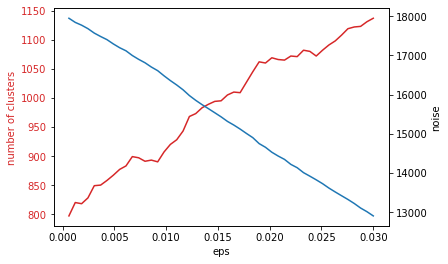

In [11]:
#figure(num=None, figsize=(15, 6), dpi=80)
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_xlabel('eps')
ax1.set_ylabel('number of clusters', color=color)
ax1.plot(eps_nums, eps_num_clusters, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

ax2.plot(eps_nums, eps_num_noise)
ax2.set_ylabel('noise')
plt.show()

In [12]:
eps_num = 0.006
print("Taking EPS as", eps_num)
# Compute DBSCAN
db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(target_similarity_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Taking EPS as 0.006
Estimated number of clusters: 881
Estimated number of noise points: 17136


In [13]:
for unique_label in set(labels):
    
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(target_texts)[class_member_mask])
    print("-------------------------------------")
    #print(Counter(class_member_mask).keys()) # equals to list(set(words))
    #Counter(words).values() # counts the elements' frequency


In cluster 0 found 1017 points
Samples
['nice. do you like shakespeare' 'bye' 'yeah. do you like shakespeare' ...
 'interesting.' 'p' 'you too.']
-------------------------------------
In cluster 1 found 44 points
Samples
['you as well..' 'you as well.' 'you as well' 'you as well.'
 'you as well.' 'you as well.' 'you as well.' 'you as well.'
 'you as well.' 'you as well.' 'you as well ...' 'you as well'
 'you as well.' 'you as well.' 'you as well.' 'you as well.'
 'you as well.' 'you as well.' 'you as well.' 'you as well' 'you as well.'
 'you as well' 'you as well.' 'you as well' 'you as well.' 'you as well'
 'you as well' 'you as well.' 'you as well.' 'you as well.' 'you as well.'
 'you as well.' 'you as well.' 'you as well.' 'you as well' 'you as well.'
 'you as well.' 'you as well.' 'you as well.' 'you as well.'
 'you as well.' 'you as well.' 'you as well' 'you as well.']
-------------------------------------
In cluster 2 found 4 points
Samples
['was it a smuggling thing' 'hi. good.'

In [14]:
with open('target_dbscan_006.pickle', 'wb') as handle:
    pickle.dump(db, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [15]:
eps_num = 0.05
print("Taking EPS as", eps_num)
# Compute DBSCAN
db = DBSCAN(eps=eps_num, min_samples=2, metric="precomputed", n_jobs=4).fit(target_similarity_matrix)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Taking EPS as 0.05
Estimated number of clusters: 1066
Estimated number of noise points: 10121


In [16]:
for unique_label in set(labels):
    
    class_member_mask = (labels == unique_label)
    print("In cluster", unique_label, "found", Counter(class_member_mask)[True], "points")
    print("Samples")
    print(np.array(target_texts)[class_member_mask])
    print("-------------------------------------")
    #print(Counter(class_member_mask).keys()) # equals to list(set(words))
    #Counter(words).values() # counts the elements' frequency


In cluster 0 found 5661 points
Samples
['nice. do you like shakespeare' "i didn't know this thanks for sharing."
 'bye' ... 'you too.' "that's true. i didn't realize that."
 'strange because chickens are so tasty.']
-------------------------------------
In cluster 1 found 2 points
Samples
['yeah interesting point. nice chat' 'yes better save than sorry.']
-------------------------------------
In cluster 2 found 865 points
Samples
["that is crazy. that can't be cheap for them."
 "really that's awful to hear." 'yes i love fish do you'
 'i know right dogs deserve that though' 'it is weird but true'
 'haha good one.' 'thanks you too.'
 "that's great one. unforgiven was awesome" 'will do. bye.'
 'yes some of them have eyelids and ears.' 'yes flow and delivery.'
 "you're probably right." "i'm terrible also. hilarious."
 'they enjoy solving a problem' 'well it was good speaking to you.'
 'not really sure maybe closer to dinosaurs' 'been good chatting'
 'good for them were you cheering for the

In [17]:
with open('target_dbscan_05.pickle', 'wb') as handle:
    pickle.dump(db, handle, protocol=pickle.HIGHEST_PROTOCOL)